<a href="https://colab.research.google.com/github/ramirog034/TQx/blob/main/Deep_Learning_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone GitHub Repo

In [ ]:
!git clone https://github.com/QuIIL/TQx

Cloning into 'TQx'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 96 (delta 5), reused 16 (delta 5), pack-reused 76 (from 1)
Receiving objects: 100% (96/96), 243.10 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (41/41), done.


# Imports

In [ ]:
import pickle
import numpy as np
import torch
import os
import pandas as pd
import os
import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from matplotlib.ticker import FuncFormatter
import csv
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Softmax Function

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting np.max(x) for numerical stability
    return 100* e_x / e_x.sum(axis=0)

# Mappings

In [ ]:
def config_for_dataset(dataset):
    if dataset in ['colon-1']:
        mapping = {'moderately differentiated cancer': 'MD',
                    'poorly differentiated cancer': 'PD',
                    'benign': 'BN',
                    'well differentiated cancer': 'WD'}
        mapping_2 = {'moderately differentiated cancer': 2,
                    'poorly differentiated cancer': 3,
                    'benign': 0,
                    'well differentiated cancer': 1}
        mapping_3 = {2: 'MD',
                    3: 'PD',
                    0: 'BN',
                    1: 'WD'}
        custom_order=['BN', 'WD', 'MD', 'PD']

        mapping = {'grade 1 cancer': 'G1',
                    'grade 2 cancer': 'G2',
                    'normal': 'BN',
                    'grade 3 cancer': 'G3',
                    'grade 4 cancer': 'G4'}
        mapping_2 = {'grade 1 cancer': 1,
                    'grade 2 cancer': 2,
                    'normal': 0,
                    'grade 3 cancer': 3,
                    'grade 4 cancer': 4}
        mapping_3 = {1:'G1',
                    2: 'G2',
                    0:'BN',
                    3:'G3',
                    4: 'G4'}
        custom_order=['BN', 'G1', 'G2', 'G3', 'G4']
    elif dataset in ['luad']:
        mapping = {'tumor': 'TUM',
                    'normal': 'NOR'}
        mapping_2 = {'tumor': 1,
                    'normal': 0}
        mapping_3 = {1:'TUM',
                    0:'NOR'}
        custom_order=['NOR', 'TUM']
    elif dataset in ['bach']:
        mapping = {'invasive carcinoma': 'IVS',
                   'in situ carcinoma': 'SITU',
                    'benign': 'BN',
                    'normal': 'NOR'}
        mapping_2 = {'invasive carcinoma': 3,
                   'in situ carcinoma': 2,
                    'benign': 1,
                    'normal': 0}
        mapping_3 = {1:'BN',
                     2: 'SITU',
                     3: 'IVS',
                    0:'NOR'}
        custom_order=['NOR', 'BN', 'SITU', 'IVS']
    elif dataset in ['bladder']:
        mapping = {'high grade cancer': 'HIGH',
                   'low grade cancer': 'LOW',
                    'normal': 'NOR'}
        mapping_2 = {'high grade cancer': 2,
                     'low grade cancer': 1,
                    'normal': 0}
        mapping_3 = {2: 'HIGH',
                    1:'LOW',
                    0:'NOR'}
        custom_order=['NOR', 'LOW', 'HIGH']

        mapping = {'stroma': 'STR',
                   'background': 'BACK',
                   'adipole': 'ADI',
                   'lymphocyte': 'LYM',
                   'debris': 'DEB',
                   'tumor': 'TUM',
                    'normal': 'NOR'}
        mapping_2 = {'stroma': 0,
                   'background': 1,
                   'adipole': 2,
                   'lymphocyte': 3,
                   'debris': 4,
                   'tumor': 5,
                    'normal': 6}
        mapping_3 = {0: 'STR',
                   1: 'BACK',
                   2: 'ADI',
                   3: 'LYM',
                   4: 'DEB',
                   5: 'TUM',
                    6: 'NOR'}
        custom_order=['STR', 'BACK', 'ADI', 'LYM', 'DEB', 'TUM', 'NOR']
    return mapping, mapping_2, mapping_3, custom_order

# Clustering

In [ ]:
%cd TQx

/content/TQx


In [ ]:
def clustering(args, features, img_label, path, postfix):
    features = torch.tensor(features).numpy()

    y = img_label
    mapping = config_for_dataset(args.dataset)[1]
    y = [mapping[i] for i in y]

    label_mapping = config_for_dataset(args.dataset)[2]
    cluster_labels_list = []

    kmeans = KMeans(n_clusters=len(label_mapping), init='k-means++', n_init='auto')
    cluster_labels = kmeans.fit_predict(features)
    cluster_labels_list.append(cluster_labels)


    return cluster_labels_list

def scale_list(original_list, scale_factor):
    scaled_list = []
    for item in original_list:
        scaled_list.extend([item] * scale_factor)
    return scaled_list

def save_string_to_file(string, file_path):
    with open(file_path, 'w') as file:
        file.write(string)

def analyze_clustering(args, raw_df, path, postfix):
    raw_df = raw_df[raw_df['match_rank'] < args.top_analyze]
    df = raw_df[raw_df['match_rank']==1]
    df['label'] = df['label'].map(args.mapping)
    k = df['label'].nunique()
    labels = df['label'].unique()
    custom_order = args.custom_order
    custom_values = df['label'].value_counts()

    fig, axes = plt.subplots(1, k, figsize=(3*k, 2.3))
    s = ''

    if args.dataset == 'colon-1':
        display = 'Colon'
    elif args.dataset == 'bladder':
        display = 'Bladder'
    elif args.dataset == 'bach':
        display = 'BACH'
    elif args.dataset == 'luad':
        display = 'WSSS4LUAD'

    green = '#55a868'
    orange = '#dd8452'
    red = '#c44f52'
    blue = '#4c72b0'

    colors = [green, blue, orange, red]

    for cluster in range(k):
        entities_counts = raw_df[raw_df[f'k = {k}'] == cluster]['entity'].value_counts().head(20).to_string()
        s += entities_counts + '\n'
        value_counts = df[df[f'k = {k}'] == cluster]['label'].value_counts().reindex(custom_order)

        value_counts = value_counts / df[df[f'k = {k}'] == cluster]['label'].value_counts().sum()
        # value_counts = value_counts / value_counts.index.map(custom_values)
        ax = axes[cluster]

        df2 = value_counts.to_frame().reset_index()
        df2.columns = ['Category', 'Count']

        sns.barplot(ax=ax,
                    x='Category',
                    y='Count',
                    data=df2,
                    palette=colors,
                    width=1/2
                    )

        ax.set_title(f'Cluster {cluster+1}')
        ax.title.set_size(17)
        ax.tick_params(axis='x', labelsize=13)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Function to format tick labels
    def format_ticks(x, pos):
        return "{:.1f}".format(x)

    # Apply formatting to both axes
    # plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
    for ax in axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    plt.tight_layout()
    plt.savefig(f'{path}/k-{k}{postfix}-within.png', dpi=600)
    file_path = f'{path}/common_terms-within.txt'
    save_string_to_file(s, file_path)

def calculate_sim(args):
    if args.dataset == 'colon-1':
        display = 'Colon'
    elif args.dataset == 'bladder':
        display = 'Bladder'
    elif args.dataset == 'bach':
        display = 'BACH'
    elif args.dataset == 'luad':
        display = 'WSSS4LUAD'
    else:
        display = args.dataset # default case

    print(f'Clustering {args.dataset}')
    postfix = args.postfix

    entity_name_path = 'entity.csv'
    entity_feature_path = 'entity_ALL_FEATURES.pkl'
    image_feature_path = f'results/{display}/all_img_features_sorted{postfix}.pkl'
    image_info_path = f'results/{display}/img_info{postfix}.txt'

    filters = args.filters
    path = f'results/{args.dataset}/{filters}_{args.top_freq_words}_{args.top_freq_features_to_combine}'

    entity_name = pd.read_csv(entity_name_path)
    with open(entity_feature_path, 'rb') as f:
        entity_feature = pickle.load(f)
    with open(image_feature_path, 'rb') as f:
        image_feature = pickle.load(f)
    with open(image_info_path, 'rb') as file:
        img_files = file.readlines()

    # FILTER 1 using semantic name
    if len(args.filter_semantic_name) != 0:
        mask = entity_name['semantic_name'].isin(args.filter_semantic_name)
        indices = entity_name.index[mask]
        entity_name = entity_name.iloc[indices].reset_index(drop=True)
        entity_feature = torch.index_select(entity_feature, 0, torch.tensor(indices))

    norm_entity_feature = entity_feature / entity_feature.norm(dim=-1, keepdim=True)
    norm_image_feature = image_feature/ image_feature.norm(dim=-1, keepdim=True)

    sim = norm_image_feature @ norm_entity_feature.T

    # FILTER 2 using top freq words
    sorted_indices = torch.argsort(sim, dim=1, descending=True)
    ranks = torch.zeros_like(sorted_indices, dtype=torch.float)
    for i in range(sim.shape[0]):  # Iterate over rows
        ranks[i, sorted_indices[i, :]] = torch.arange(sim.shape[1], dtype=torch.float) + 1
    ranks = torch.sum(ranks, dim=0)/sim.shape[0]  # avg rank of each word
    entity_name['avg_ranking'] = ranks.numpy()
    entity_name = entity_name.nsmallest(args.top_freq_words, 'avg_ranking')
    indices = entity_name.index
    entity_feature = torch.index_select(entity_feature, 0, torch.tensor(indices))
    entity_name = entity_name.reset_index(drop=True)

    norm_entity_feature = entity_feature / entity_feature.norm(dim=-1, keepdim=True)
    sim = norm_image_feature @ norm_entity_feature.T

    image_text_representation = torch.matmul(sim, entity_feature)/torch.sum(sim,dim=1)[:,None]

    if not os.path.exists(f'{path}'):
        os.makedirs(f'{path}')
    with open(f'{path}/image_text_representation{postfix}.pkl', 'wb') as file:
        pickle.dump(image_text_representation, file)

    top_values, top_indices = torch.topk(sim, k=args.top_freq_features_to_combine, dim=1) # shape (num_img, top_entities)
    m = torch.nn.Softmax(dim=1)
    softmax_output = m(sim)
    top_values_2, top_indices_2 = torch.topk(softmax_output, k=args.top_freq_features_to_combine, dim=1)

    if args.dataset == 'gastric':
        split = '.jpg,'.encode('utf-8')
    elif args.dataset == 'luad':
        split = '.png,'.encode('utf-8')
    else:
        split = ','.encode('utf-8')

    img_paths = [file.split(split)[0].decode('utf-8') for file in img_files]
    raw_labels = [file.split(split)[1][:-2].decode('utf-8') for file in img_files]

    # Create lists with repeated values for the DataFrame
    repeated_img_paths = [item for item in img_paths for _ in range(args.top_freq_features_to_combine)]
    repeated_raw_labels = [item for item in raw_labels for _ in range(args.top_freq_features_to_combine)]
    match_ranks = [i for _ in range(len(img_files)) for i in range(args.top_freq_features_to_combine)]


    top_idx = pd.Series(top_indices.view(-1))
    entity = top_idx.map(entity_name['entity_name'].to_dict())
    entity_semantic = top_idx.map(entity_name['semantic_name'].to_dict())

    probability = top_values.view(-1)
    cosine_sim = top_values_2.view(-1)

    if not os.path.exists(path):
        os.makedirs(path)
    cluster_labels_list = clustering(args, image_text_representation, raw_labels, path, postfix)[0]

    columns = ["image_path", "label", "match_rank", "entity", "entity_semantic", "probability", 'cosine_sim']
    df = pd.DataFrame({
        "image_path": repeated_img_paths,
        "label": repeated_raw_labels,
        "match_rank": match_ranks,
        "entity": entity,
        "entity_semantic": entity_semantic,
        "probability": probability,
        "cosine_sim": cosine_sim
    })

    filters = ('_').join(args.filter_semantic_name).replace(' ','_').replace(';','')
    df[f"k = {df['label'].nunique()}"] = np.repeat(cluster_labels_list, args.top_freq_features_to_combine)
    df_csv = df[df['match_rank'] < args.top_words_in_csv]
    df_csv.to_csv(f'{path}/top_{args.top_words_in_csv}{args.postfix}.csv', index=False)

    analyze_clustering(args, df, path, postfix)

def measure_metrics(dataset, pred, label):
    if dataset in ['colon-1', 'colon-2', 'prostate-1', 'prostate-2', 'prostate-3',
                   'gastric','kidney','liver','bladder','bach','panda']:
        acc = accuracy_score(label, pred)

        excluded_class = 0

        temp_1 = []
        temp_2 = []
        for i, l in enumerate(label):
            if l != excluded_class:
                temp_1.append(l)
                temp_2.append(pred[i])
        acc_grading = accuracy_score(temp_1, temp_2)
        f1 = f1_score(label, pred, average='macro')
        kappa = cohen_kappa_score(label, pred, labels=np.arange(len(np.unique(pred))), weights='quadratic')
        cm = confusion_matrix(label, pred, labels=[0,1,2,3])
        result = (acc, acc_grading, f1, kappa, cm)

    else:
        acc = accuracy_score(label, pred)
        f1 = f1_score(label, pred, average='macro')
        rec = recall_score(label, pred, average='macro')
        pre = precision_score(label, pred, average='macro')
        cm = confusion_matrix(label, pred, labels=[0,1,2,3])
        result = (acc, pre, f1, rec, cm)

    return result

# Classification

In [ ]:
def classify(args):
    print(args.test, args.feature_type, args.filter_semantic_name)

    class MLP(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(512, 2048)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(2048, output_size)
            self.bnorm = nn.BatchNorm1d(2048)

        def forward(self, x):
            x = self.fc1(x)
            x = self.bnorm(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    mapping = config_for_dataset(args.dataset)[1]

    filters = args.filters
    path1 = f'results/{args.dataset}/{filters}_{args.top_freq_words}_{args.top_freq_features_to_combine}'
    path2 = f'results/{args.test}/{filters}_{args.top_freq_words}_{args.top_freq_features_to_combine}'

    if args.feature_type == 'text':
        train_feature_path = f'{path1}/image_text_representation_train.pkl'
        valid_feature_path = f'{path1}/image_text_representation_valid.pkl'
        test_feature_path = f'{path2}/image_text_representation_test.pkl'
    elif args.feature_type == 'image':
        train_feature_path = f'results/{args.dataset}/all_img_features_sorted_train.pkl'
        valid_feature_path = f'results/{args.dataset}/all_img_features_sorted_valid.pkl'
        test_feature_path = f'results/{args.test}/all_img_features_sorted_test.pkl'

    if args.test in ['colon-2', 'prostate-2', 'prostate-3', 'k16']:
        test_feature_path = test_feature_path.replace('_test', '')

    with open(train_feature_path, 'rb') as file:
        train_feature = pickle.load(file)
    image_info_path = f'results/{args.dataset}/img_info_train.txt'
    with open(image_info_path, 'r') as file:
        train_img_files = file.readlines()
    if args.dataset == 'gastric':
        split = '.jpg,'
    elif args.dataset == 'luad':
        split = '.png,'
    else:
        split = ','
    train_label = [file.split(split)[1][:-2] for file in train_img_files]
    train_label_list = [mapping[label] for label in train_label]
    train_label = torch.tensor(train_label_list)

    with open(valid_feature_path, 'rb') as file:
        valid_feature = pickle.load(file)
    image_info_path = f'results/{args.dataset}/img_info_valid.txt'
    with open(image_info_path, 'r') as file:
        valid_img_files = file.readlines()
    valid_label = [file.split(split)[1][:-2] for file in valid_img_files]
    valid_label = [mapping[label] for label in valid_label]

    with open(test_feature_path, 'rb') as file:
        test_feature = pickle.load(file)
    image_info_path = f'results/{args.test}/img_info_test.txt'
    with open(image_info_path, 'r') as file:
        test_img_files = file.readlines()
    test_label = [file.split(split)[1][:-2] for file in test_img_files]
    test_label = [mapping[label] for label in test_label]

    # Define hyperparameters
    input_size = 512  # Size of the input features
    hidden_size = 4096  # Size of the hidden layer
    output_size = len(set(test_label))

    # Initialize model, loss function, and optimizer
    device = torch.device('cuda:2')

    criterion = nn.CrossEntropyLoss()


    # Training loop
    num_epochs = 300

    temp = None
    metrics_list = [
        [],[],[],[]
    ]
    for seed in args.seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model = MLP(input_size, hidden_size, output_size).to(device)
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=0.01)
        max_f1 = 0
        for _ in range(num_epochs):
            optimizer.zero_grad()
            train_pred = model(train_feature.to(device))
            loss = criterion(train_pred, train_label.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # print(torch.argmax(train_pred[0]))
            train_pred = torch.argmax(train_pred, dim=1).tolist()

            val_predictions = model(valid_feature.to(device))
            val_predictions = torch.argmax(val_predictions, dim=1).tolist()

            test_predictions = model(test_feature.to(device))
            test_predictions = torch.argmax(test_predictions, dim=1).tolist()

            metrics = measure_metrics(args.dataset, val_predictions, valid_label)
            if metrics[2] > max_f1:
                max_f1 = metrics[2]
                temp = measure_metrics(args.dataset, test_predictions, test_label)[:-1]
        for i in range(4):
            metrics_list[i].append(temp[i])
    new_row = [args.test, filters, args.feature_type,
               f"{np.mean(metrics_list[0]):.4f}+{np.std(metrics_list[0]):.4f}",
               f"{np.mean(metrics_list[1]):.4f}+{np.std(metrics_list[1]):.4f}",
               f"{np.mean(metrics_list[2]):.4f}+{np.std(metrics_list[2]):.4f}",
               f"{np.mean(metrics_list[3]):.4f}+{np.std(metrics_list[3]):.4f}"]

    # File path of the existing CSV file
    file_path = 'classification.csv'

    # Open the CSV file in append mode
    with open(file_path, 'a', newline='') as file:
        # Create a CSV writer object
        writer = csv.writer(file)

        # Write the new row to the CSV file
        writer.writerow(new_row)


    print(temp)

def plotting_data_split(args):
    tsne = TSNE(n_components=2,
                random_state=42, verbose=0)

    train_feature_path = f'results/{args.dataset}/Neoplastic_Process_1000_1000/image_text_representation_train.pkl'
    with open(train_feature_path, 'rb') as f:
        train_feature = pickle.load(f)
    tsne_train = tsne.fit_transform(train_feature)

    valid_feature_path = f'results/{args.dataset}/Neoplastic_Process_1000_1000/image_text_representation_valid.pkl'
    with open(valid_feature_path, 'rb') as f:
        valid_feature = pickle.load(f)
    tsne_valid = tsne.fit_transform(valid_feature)

    test_feature_path = f'results/{args.dataset}/Neoplastic_Process_1000_1000/image_text_representation_test.pkl'
    with open(test_feature_path, 'rb') as f:
        test_feature = pickle.load(f)
    tsne_test = tsne.fit_transform(test_feature)

    img_info_train = f'results/{args.dataset}/img_info_train.txt'
    img_info_valid = f'results/{args.dataset}/img_info_valid.txt'
    img_info_test = f'results/{args.dataset}/img_info_test.txt'

    split = '.jpg,' if args.dataset == 'gastric' else ','
    mapping = config_for_dataset(args.dataset)
    with open(img_info_train, 'r') as file:
        img_files_train = file.readlines()
    label_train = [mapping[1][file.split(split)[1][:-2]] for file in img_files_train]
    with open(img_info_valid, 'r') as file:
        img_files_valid = file.readlines()
    label_valid = [mapping[1][file.split(split)[1][:-2]] for file in img_files_valid]
    with open(img_info_test, 'r') as file:
        img_files_test = file.readlines()
    label_test = [mapping[1][file.split(split)[1][:-2]] for file in img_files_test]

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    colors = ['blue', 'skyblue', 'aqua', 'yellow', 'gold', 'khaki', 'green', 'limegreen', 'lightgreen', 'red', 'coral', 'salmon']
    i = 0
    for class_idx in np.unique(label_train):
        for feature, label in zip([tsne_train, tsne_valid, tsne_test], [label_train, label_valid, label_test]):
            axs.scatter(feature[label == class_idx, 0], feature[label == class_idx, 1], c=colors[i])
            i += 1
    plt.savefig(f'test.png', dpi=600)

# Main Function

In [ ]:
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument('--dataset', choices=['colon-1','bach','bladder', 'luad'], default='luad')
    parser.add_argument('--test', choices=['colon-1','bach','bladder', 'luad'], default='')
    parser.add_argument('--feature_type', type=str, default='image')
    parser.add_argument('--seed', default=list(range(50)))
    parser.add_argument('--plot', choices=['tsne','umap'], default='umap')
    parser.add_argument('--filter_semantic_name', nargs='+', default=['Neoplastic Process;'])
    parser.add_argument('--filters',default='Neoplastic_Process')
    parser.add_argument('--postfix', default='_test')
    parser.add_argument('--text_split_range', type=int, default=1)
    parser.add_argument('--img_split_range', type=int, default=8192)
    parser.add_argument('--device', type=int, default=2)
    parser.add_argument('--draw', type=bool, default=False)
    parser.add_argument('--num_workers', type=int, default=10)

    parser.add_argument('--top_words_in_csv', type=int, default=20)
    parser.add_argument('--top_analyze', default=50)
    parser.add_argument('--top_freq_features_to_combine', type=int, default=1000)
    parser.add_argument('--top_freq_words', type=int, default=1000)
    parser.add_argument('--n_clusters', default=[2,3,4,5,6,7])
    parser.add_argument('--mode', default='0')

    parser.add_argument('--mapping', default=
                        {'moderately differentiated cancer': 'MD',
                        'poorly differentiated cancer': 'PD',
                        'benign': 'BN',
                        'well differentiated cancer': 'WD'})
    parser.add_argument('--custom_order', default=['BN', 'WD', 'MD', 'PD'])

    args, unknown = parser.parse_known_args() # Modified to handle unknown arguments

    args.mapping = config_for_dataset(args.dataset)[0]
    args.custom_order = config_for_dataset(args.dataset)[-1]

    # Calculate similarity of
    return calculate_sim(args)

To improve, get rid of the combination and instead pass the postfix argument to it. Probably test. Then, if we want to do this for a different dataset, change the default --dataset argument. Not sure how to get the classification working, maybe the --mode argument.

Clustering luad


/tmp/ipython-input-4114224097.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).numpy()
/tmp/ipython-input-4114224097.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(args.mapping)
/tmp/ipython-input-4114224097.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax,
/tmp/ipython-input-4114224097.py:68: UserWarning: The palette list has more values (4) than needed (2), which ma

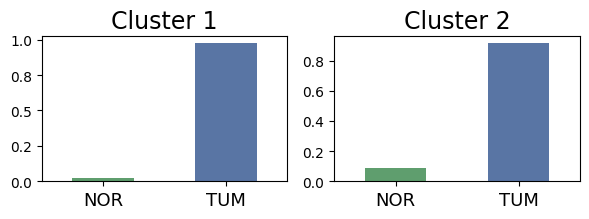

In [ ]:
cluster_labels_list = []
if __name__ == '__main__':
    cluster_labels_list = main()

# T-SNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
%cd ..

/content


In [ ]:
len(cluster_labels_list)

TypeError: object of type 'NoneType' has no len()

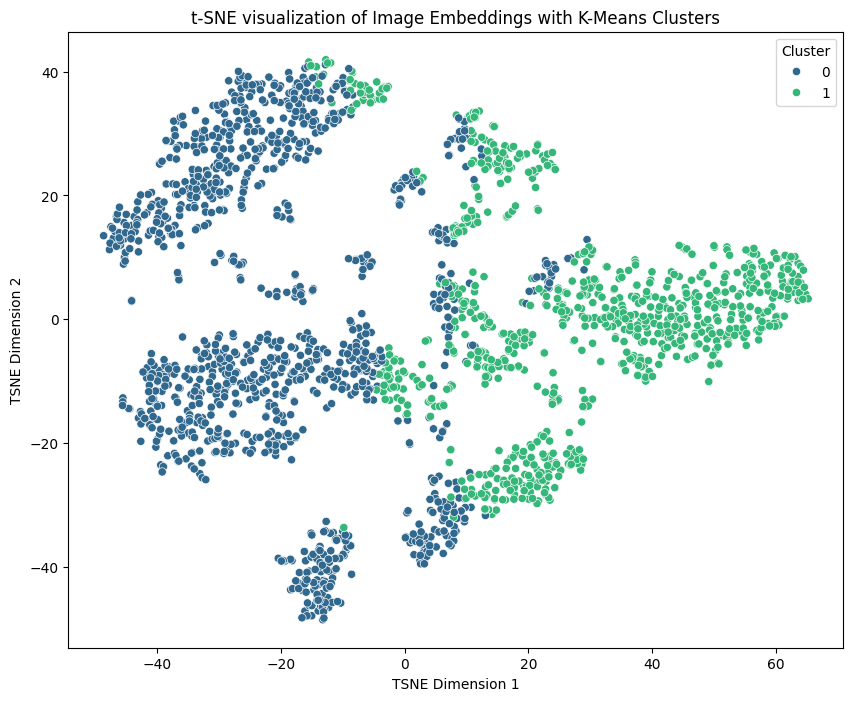

In [ ]:
# Assuming you have already run the clustering function to get cluster_labels_list
# and have access to the image_text_representation.pkl file

# Load the image text representation
with open('image_text_representation_test.pkl', 'rb') as f:
    image_embeddings = pickle.load(f)

# Assuming 'cluster_labels_list' contains the cluster assignments for your embeddings
# If not, you'll need to run the clustering code first to generate it.
# For this example, let's assume you have a variable named 'cluster_labels'
# that holds the cluster labels for the 'image_embeddings'.
# Replace this with your actual cluster labels if they are stored differently.
# For demonstration, let's generate dummy cluster labels (replace with your actual labels)
# You should get the cluster labels from the output of your clustering function call.
# For instance, if you ran:
# cluster_labels_list = clustering(args, image_text_representation, raw_label, path, postfix)
# cluster_labels = cluster_labels_list[0] # Assuming clustering returns a list of label arrays

# As per the code, the clustering is performed within calculate_sim.
# We need to call calculate_sim first to generate the cluster labels and dataframe.
# Let's define a minimal args object for calculate_sim for demonstration purposes.
# You should replace these with the actual arguments you used for calculate_sim.
class Args:
    def __init__(self):
        self.dataset = 'luad'
        self.test = 'luad'
        self.feature_type = 'text'
        self.seed = [0]
        self.plot = 'umap'
        self.filter_semantic_name = ['Neoplastic Process;']
        self.filters = 'Neoplastic_Process'
        self.postfix = '_test'
        self.text_split_range = 1
        self.img_split_range = 8192
        self.device = 2
        self.draw = False
        self.num_workers = 10
        self.top_words_in_csv = 20
        self.top_analyze = 50
        self.top_freq_features_to_combine = 1000
        self.top_freq_words = 1000
        self.n_clusters = [2,3,4,5,6,7]
        self.mode = '0'
        self.mapping = {}
        self.custom_order = []

args = Args()

# To get the cluster labels, we need to call calculate_sim.
# However, calculate_sim has dependencies on 'img_files' and 'split_type' which are not defined.
# To proceed with the visualization, let's assume we can load a dataframe
# that contains both the embeddings and the cluster labels from a previous run.
# Based on the code, calculate_sim saves a csv file like 'top_20_test.csv'
# which contains the cluster labels in a column like 'k = 2'.

# Let's try to load the generated CSV and use it for t-SNE
try:
    # Adjust the path based on your actual output directory and filename
    df_results = pd.read_csv('top_20_test.csv')

    # Extract embeddings and cluster labels from the dataframe
    # Note: The embeddings are NOT in this CSV. The CSV contains info about the top entities.
    # We need to load the embeddings from the pkl file and the labels from the dataframe.

    # Load the image text representation (embeddings)
    with open('image_text_representation_test.pkl', 'rb') as f:
        image_embeddings = pickle.load(f)

    # Get the cluster labels from the dataframe.
    # We need to make sure the order of embeddings matches the order of labels in the dataframe.
    # The dataframe contains multiple rows per image (due to top_words_in_csv).
    # We need one label per image. Let's assume the first row for each image has the correct cluster label.
    df_unique_images = df_results.drop_duplicates(subset=['image_path']).reset_index(drop=True)
    # Find the column containing cluster labels. It should be like 'k = X'
    cluster_col = [col for col in df_unique_images.columns if col.startswith('k = ')][0]
    cluster_labels = df_unique_images[cluster_col].values

    # Ensure the number of embeddings matches the number of unique images/labels
    if len(image_embeddings) != len(cluster_labels):
        print("Mismatch between number of embeddings and cluster labels. Cannot perform t-SNE.")
    else:
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(image_embeddings)

        # Create a DataFrame for plotting
        df_plot = pd.DataFrame(embeddings_2d, columns=['TSNE_Dim1', 'TSNE_Dim2'])
        df_plot['Cluster'] = cluster_labels

        # Plot the t-SNE results
        plt.figure(figsize=(10, 8))
        scatter = sns.scatterplot(
            x='TSNE_Dim1',
            y='TSNE_Dim2',
            hue='Cluster',
            data=df_plot,
            palette='viridis', # You can choose a different color palette
            legend='full'
        )
        plt.title('t-SNE visualization of Image Embeddings with K-Means Clusters')
        plt.xlabel('TSNE Dimension 1')
        plt.ylabel('TSNE Dimension 2')
        plt.show()

except FileNotFoundError:
    print("Could not find the CSV file with clustering results. Please run the calculate_sim function first.")
except Exception as e:
    print(f"An error occurred: {e}")